In [4]:
import numpy
import matplotlib.pyplot
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
import os
os.getcwd()

'/Users/IjiriYosuke/Documents/GitHub/ELTDM-Project'

In [6]:
#Read the data
data = numpy.loadtxt("./Data/test.txt", dtype='uint16')
print(data)
print(type(data))

[[1 2]
 [1 3]
 [2 4]
 [2 5]
 [3 1]
 [3 4]
 [5 3]]
<class 'numpy.ndarray'>


In [7]:
#Make a list of adjacency lists (first element is the node of origin)
nodeId = numpy.unique(data)
nrow = len(data)
adj_list = []

for n in nodeId:
    adj = []
    for i in range(nrow):
        if data[i, 0] == n:
            adj.append(data[i, 1])
        if data[i, 1] == n:
            adj.append(data[i, 0])
    adj = list(set(adj)) 
    adj.insert(0, n)
    adj_list.append(adj)
print(adj_list)

[[1, 2, 3], [2, 1, 4, 5], [3, 1, 4, 5], [4, 2, 3], [5, 2, 3]]


In [8]:
#Make tuple for each node
class tuples():
    def __init__(self, targetId, sourceId, distance, status, weight, pathInfo, adjList) :
        self.targetId = targetId
        self.sourceId = sourceId
        self.distance = distance
        self.status = status
        self.weight = weight
        self.pathInfo = pathInfo
        self.adjList = adjList

network = []
for n in nodeId:
    v = tuples(targetId = n, sourceId = n, distance = 0, status = 'a', weight = 1, pathInfo = [], adjList = [])
    for i in range(len(adj_list)):
        if adj_list[i][0] == n:
            v.adjList = adj_list[i][1:len(adj_list[i])]
            break
    network.append([v.targetId, v.sourceId, v.distance, v.status, v.weight, v.pathInfo, v.adjList])
print(network)

[[1, 1, 0, 'a', 1, [], [2, 3]], [2, 2, 0, 'a', 1, [], [1, 4, 5]], [3, 3, 0, 'a', 1, [], [1, 4, 5]], [4, 4, 0, 'a', 1, [], [2, 3]], [5, 5, 0, 'a', 1, [], [2, 3]]]


In [97]:
for i in range(len(network)):
    print(network[i])

[1, 1, 0, 'a', 1, [], [2, 3]]
[2, 2, 0, 'a', 1, [], [1, 4, 5]]
[3, 3, 0, 'a', 1, [], [1, 4, 5]]
[4, 4, 0, 'a', 1, [], [2, 3]]
[5, 5, 0, 'a', 1, [], [2, 3]]


AttributeError: 'list' object has no attribute 'split'

Parallelization part

In [10]:
#sc.stop()
from pyspark import SparkContext
#import copy in order to do deepcopy of tuples
from copy import deepcopy

sc = SparkContext()
sc.version

'2.4.0'

In [264]:
#Set a dataset and create key-value pairs
rdd = sc.parallelize(network)
rdd = rdd.map(lambda x: (x[0], x[1:]))
rdd.collect()

[(1, [1, 0, 'a', 1, [], [2, 3]]),
 (2, [2, 0, 'a', 1, [], [1, 4, 5]]),
 (3, [3, 0, 'a', 1, [], [1, 4, 5]]),
 (4, [4, 0, 'a', 1, [], [2, 3]]),
 (5, [5, 0, 'a', 1, [], [2, 3]])]

Stage 1 - Map

In [265]:
def stage1_map(p):    
    result = []
    if p[1][2] == 'a':
        p[1][2] = 'i'
        p[1][1] += 1
        p[1][4].append(p[0])
        x = deepcopy(p)
        result.append(x)
        temp = p[1][5].copy()
        for i in range(len(temp)):
            k = temp[i]
            p[1][2] = 'a'
            p[1][5] = []
            y = deepcopy(p)
            result.append((k, y[1]))
    return result
pos_map1 = rdd.flatMap(stage1_map)
pos_map1.collect()

[(1, [1, 1, 'i', 1, [1], [2, 3]]),
 (2, [1, 1, 'a', 1, [1], []]),
 (3, [1, 1, 'a', 1, [1], []]),
 (2, [2, 1, 'i', 1, [2], [1, 4, 5]]),
 (1, [2, 1, 'a', 1, [2], []]),
 (4, [2, 1, 'a', 1, [2], []]),
 (5, [2, 1, 'a', 1, [2], []]),
 (3, [3, 1, 'i', 1, [3], [1, 4, 5]]),
 (1, [3, 1, 'a', 1, [3], []]),
 (4, [3, 1, 'a', 1, [3], []]),
 (5, [3, 1, 'a', 1, [3], []]),
 (4, [4, 1, 'i', 1, [4], [2, 3]]),
 (2, [4, 1, 'a', 1, [4], []]),
 (3, [4, 1, 'a', 1, [4], []]),
 (5, [5, 1, 'i', 1, [5], [2, 3]]),
 (2, [5, 1, 'a', 1, [5], []]),
 (3, [5, 1, 'a', 1, [5], []])]

Stage 1 - Reduce

In [247]:
def stage1_reduce(v):
    ...

Visualisation Part

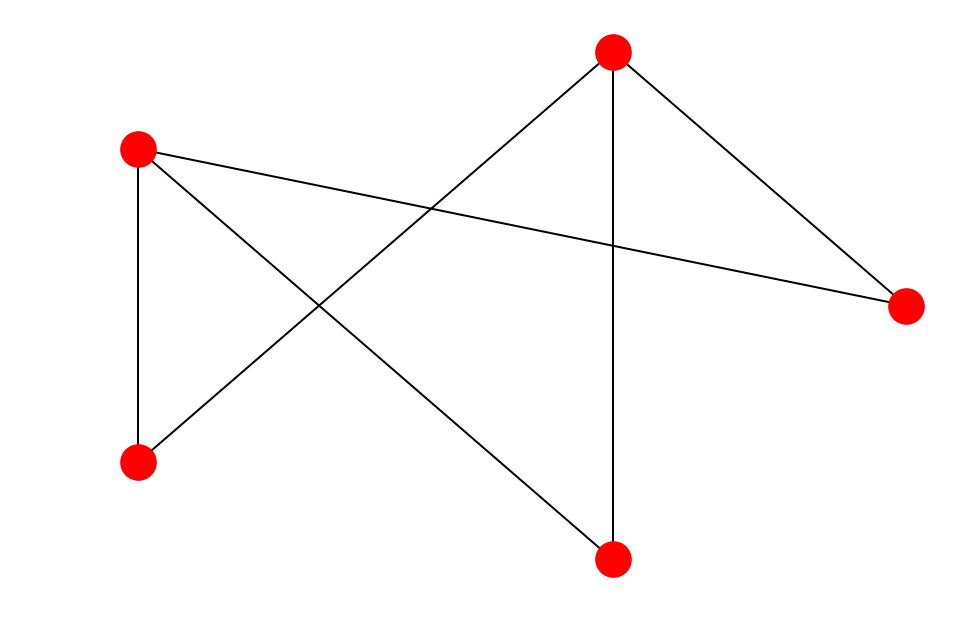

In [248]:
#Visualisation of the graph
#This is just for reference for now
import pandas
import networkx as nx
import matplotlib.pyplot as plt

def draw_graph(graph):

    # extract nodes from graph
    nodes = set([n1 for n1, n2 in graph] + [n2 for n1, n2 in graph])

    # create networkx graph
    G=nx.Graph()

    # add nodes
    for node in nodes:
        G.add_node(node)

    # add edges
    for edge in graph:
        G.add_edge(edge[0], edge[1])

    # draw graph
    pos = nx.shell_layout(G)
    nx.draw(G, pos)

    # show graph
    plt.show()
    
draw_graph(data)
